<a href="https://colab.research.google.com/github/NOORAHMED3676/My_projects/blob/main/OLA%20-%20Ensemble_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Project overview and objectives**

#####**Objective**: Predict whether a driver will leave Ola using monthly driver attributes and performance history.



#####**Business context**: Driver churn increases acquisition costs and hurts morale; retaining drivers is significantly cheaper than replacing them.

#####**Deliverables**: Clean dataset, engineered features, class imbalance treatment, ensemble models (bagging + boosting), evaluation (ROC AUC, classification report), and actionable recommendations.

###**Data understanding and loading**

######**Inputs**: Monthly records for 2019–2020 with demographics, tenure, performance, and dates.

######**Key identifiers**: Driver_ID (unique). Multiple monthly rows per driver.

######**Target definition**: Target = 1 if LastWorkingDate is present; else 0.

In [1]:
# 1. Setup
import warnings; warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

# Model & preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

# Imbalance handling
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Bagging & boosting
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier

# Optional: use XGBoost if available
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

# 2. Load data
df = pd.read_csv("/content/ola_driver_scaler.csv")

# 3. Basic structure
print(df.shape)
print(df.head())
print(df.dtypes)

(19104, 14)
   Unnamed: 0    MMM-YY  Driver_ID   Age  Gender City  Education_Level  \
0           0  01/01/19          1  28.0     0.0  C23                2   
1           1  02/01/19          1  28.0     0.0  C23                2   
2           2  03/01/19          1  28.0     0.0  C23                2   
3           3  11/01/20          2  31.0     0.0   C7                2   
4           4  12/01/20          2  31.0     0.0   C7                2   

   Income Dateofjoining LastWorkingDate  Joining Designation  Grade  \
0   57387      24/12/18             NaN                    1      1   
1   57387      24/12/18             NaN                    1      1   
2   57387      24/12/18        03/11/19                    1      1   
3   67016      11/06/20             NaN                    2      2   
4   67016      11/06/20             NaN                    2      2   

   Total Business Value  Quarterly Rating  
0               2381060                 2  
1               -665480     

###**Exploratory data analysis**

**Focus:** Data types, missingness, distributions, outliers, and relationships.

**Dates:** Convert MMMM-YY, Date Of Joining, LastWorkingDate to datetime.

**Tenure and recency:** Create tenure months and reporting month index to track trends

LastWorkingDate         0.915410
Age                     0.003193
Gender                  0.002722
Unnamed: 0              0.000000
Driver_ID               0.000000
City                    0.000000
Education_Level         0.000000
Income                  0.000000
MMM-YY                  0.000000
Dateofjoining           0.000000
Joining Designation     0.000000
Grade                   0.000000
Total Business Value    0.000000
Quarterly Rating        0.000000
Report_Month            0.000000
target                  0.000000
tenure_months           0.000000
dtype: float64


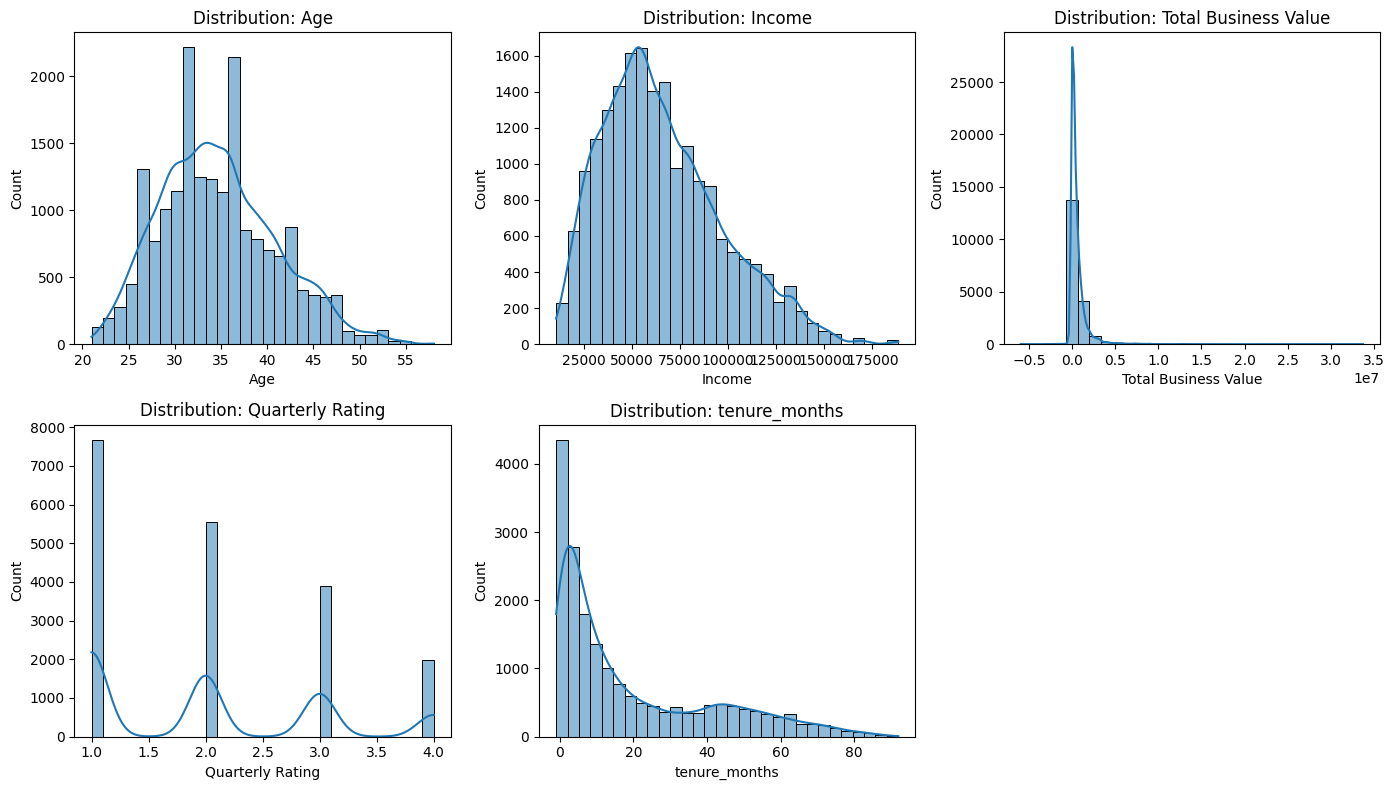

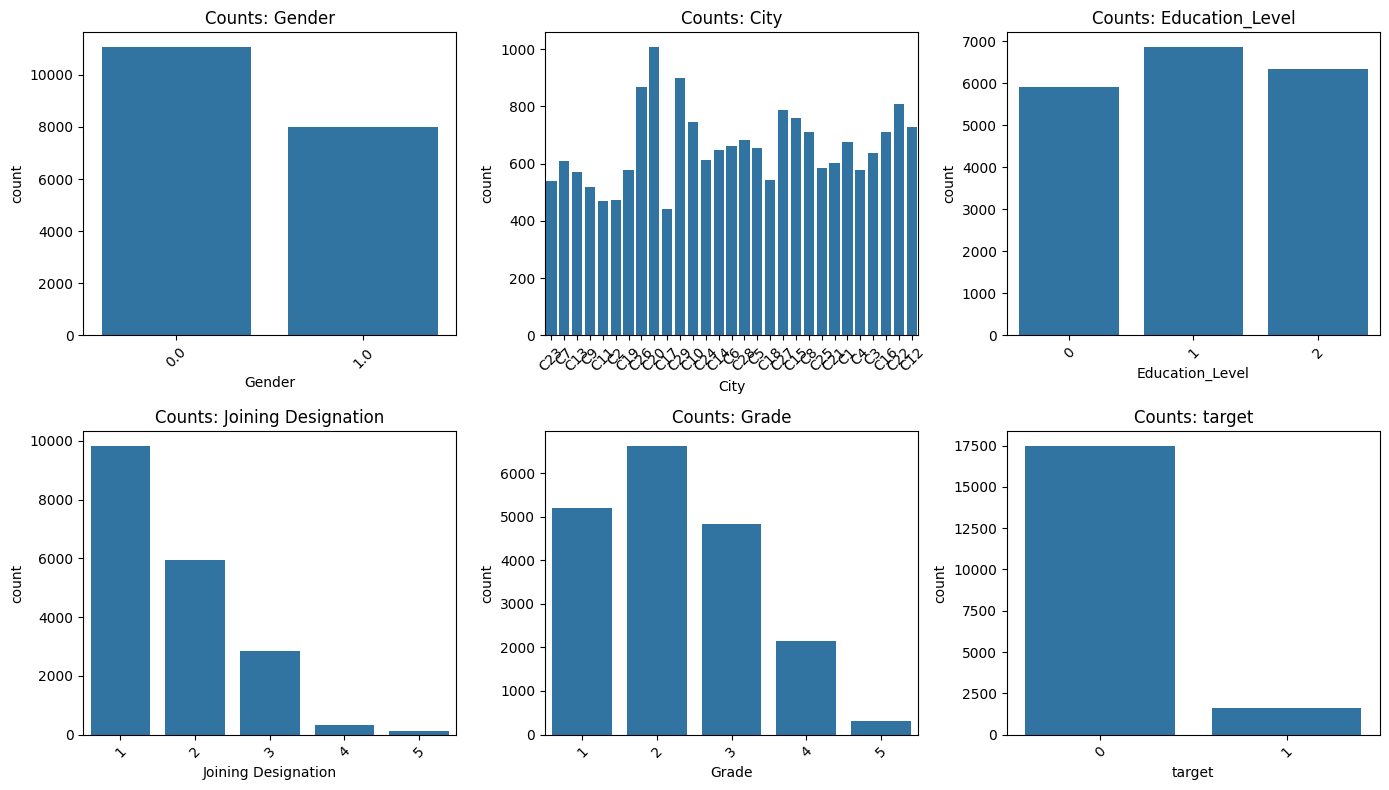

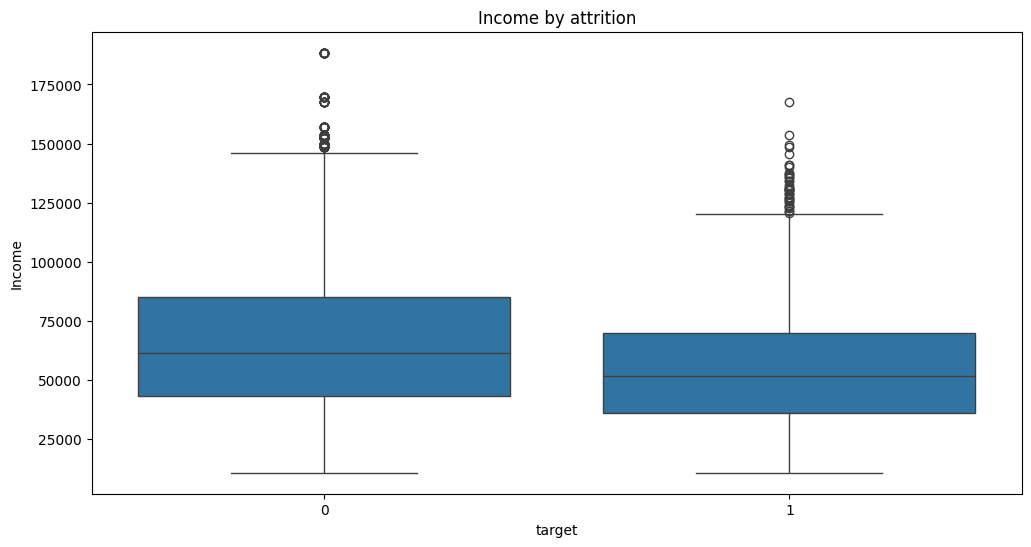

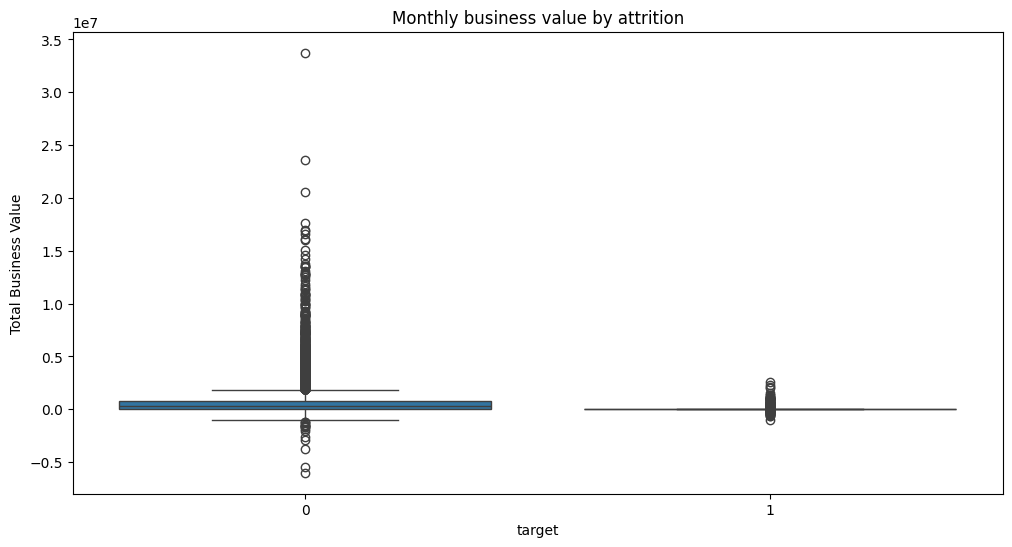

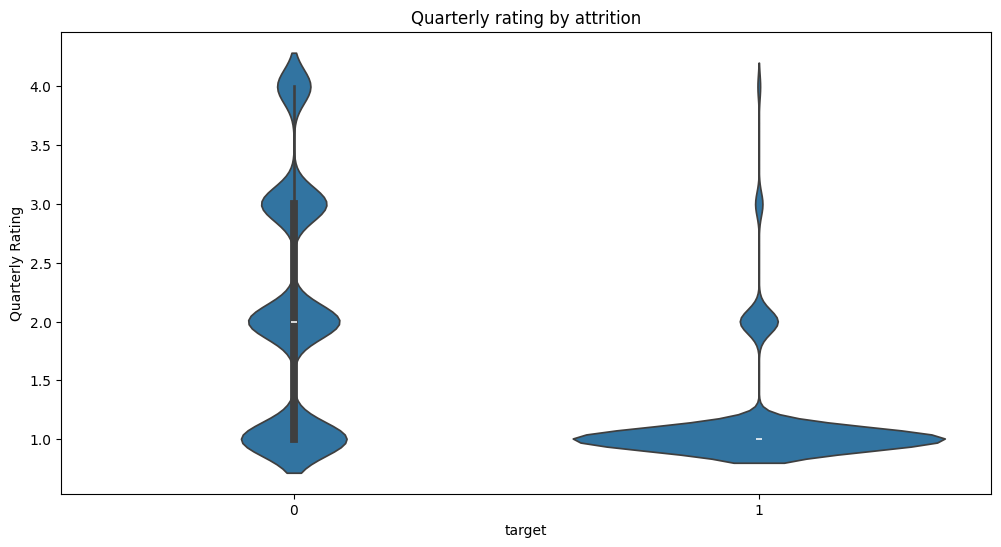

In [2]:
# Convert date columns
def parse_month_year(s):
    try:
        return pd.to_datetime(s, format="%B-%y")  # e.g., "January-20"
    except:
        try:
            return pd.to_datetime(s, format="%b-%y")  # fallback "Jan-20"
        except:
            return pd.to_datetime(s, errors='coerce')

df['Report_Month'] = df['MMM-YY'].apply(parse_month_year)
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'], errors='coerce')
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'], errors='coerce')

# Target creation
df['target'] = np.where(df['LastWorkingDate'].notna(), 1, 0)

# Tenure in months at reporting
# Calculate the difference in days and convert to approximate months
time_difference_days = (df['Report_Month'] - df['Dateofjoining']).dt.days
df['tenure_months'] = (time_difference_days / (365.25 / 12)).round()

# Quick missingness check
missing = df.isna().mean().sort_values(ascending=False)
print(missing)

# Univariate plots
num_cols = ['Age','Income','Total Business Value','Quarterly Rating','tenure_months']
cat_cols = ['Gender','City','Education_Level','Joining Designation','Grade','target']

plt.figure(figsize=(14,8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2,3,i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution: {col}")
plt.tight_layout(); plt.show()

plt.figure(figsize=(14,8))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(2,3,i)
    sns.countplot(x=df[col])
    plt.title(f"Counts: {col}")
    plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

# Bivariate: target vs key features
plt.figure(figsize=(12,6))
sns.boxplot(x='target', y='Income', data=df)
plt.title("Income by attrition")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x='target', y='Total Business Value', data=df)
plt.title("Monthly business value by attrition")
plt.show()

plt.figure(figsize=(12,6))
sns.violinplot(x='target', y='Quarterly Rating', data=df)
plt.title("Quarterly rating by attrition")
plt.show()


###**Data preprocessing and aggregation**
**Why aggregate:** Multiple monthly rows per driver conflict with a single target. Summarize per Driver_ID.

**Approach:** For each driver, compute last-known attributes, trends (increase flags), and summary stats.

In [3]:
# Prepare order within each driver by Report_Month
df_sorted = df.sort_values(['Driver_ID','Report_Month'])

# Trend features: income increase and rating increase (last vs first)
trend = df_sorted.groupby('Driver_ID').agg(
    income_first=('Income', 'first'),
    income_last=('Income', 'last'),
    rating_first=('Quarterly Rating', 'first'),
    rating_last=('Quarterly Rating', 'last'),
    tenure_last=('tenure_months','last'),
    age_last=('Age','last'),
    gender=('Gender','last'),
    city=('City','last'),
    edu=('Education_Level','last'),
    join_desig=('Joining Designation','last'),
    grade_last=('Grade','last'),
    business_mean=('Total Business Value','mean'),
    business_std=('Total Business Value','std'),
    business_min=('Total Business Value','min'),
    business_max=('Total Business Value','max'),
    income_mean=('Income','mean'),
    income_std=('Income','std'),
    rating_mean=('Quarterly Rating','mean'),
    rating_std=('Quarterly Rating','std'),
    target=('target','max'),  # if ever had LastWorkingDate, mark as churned
)

trend['income_increase'] = (trend['income_last'] > trend['income_first']).astype(int)
trend['rating_increase'] = (trend['rating_last'] > trend['rating_first']).astype(int)

# Robustness: fill std NaNs (if only one month) with 0
for c in ['business_std','income_std','rating_std']:
    trend[c] = trend[c].fillna(0)

# Derived productivity ratios
trend['business_per_tenure'] = trend['business_mean'] / trend['tenure_last'].replace({0:np.nan})
trend['income_per_tenure'] = trend['income_mean'] / trend['tenure_last'].replace({0:np.nan})
trend[['business_per_tenure','income_per_tenure']] = trend[['business_per_tenure','income_per_tenure']].fillna(0)

print(trend.head())
print(trend.shape)
print(trend['target'].value_counts(normalize=True))


           income_first  income_last  rating_first  rating_last  tenure_last  \
Driver_ID                                                                      
1                 57387        57387             2            2          2.0   
2                 67016        67016             1            1          1.0   
4                 65603        65603             1            1          4.0   
5                 46368        46368             1            1          2.0   
6                 78728        78728             1            2          4.0   

           age_last  gender city  edu  join_desig  ...  business_max  \
Driver_ID                                          ...                 
1              28.0     0.0  C23    2           1  ...       2381060   
2              31.0     0.0   C7    2           2  ...             0   
4              43.0     0.0  C13    2           2  ...        350000   
5              29.0     0.0   C9    0           1  ...        120360   
6      

###**Feature engineering and encoding**
**Engineered features:** Trend flags, summary stats, tenure-based rates.

**Encoding:** One-hot for City, Joining Designation, Grade; binary already for Gender and Education_Level.

**Imputation:** KNN for numeric, most-frequent for categoricals.

In [4]:
# Feature sets
numerical_features = [
    'age_last','tenure_last',
    'income_first','income_last','income_mean','income_std','income_per_tenure',
    'business_mean','business_std','business_min','business_max','business_per_tenure',
    'rating_first','rating_last','rating_mean','rating_std'
]
binary_features = ['gender','edu','income_increase','rating_increase']
categorical_features = ['city','join_desig','grade_last']

# Assemble X, y
X = trend[numerical_features + binary_features + categorical_features]
y = trend['target']

# Preprocessor: KNN for numeric, SimpleImputer+OHE for categorical
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # keeps binary_features as-is
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Class weights for imbalance
classes = np.array([0,1])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
cw = {cls: w for cls, w in zip(classes, class_weights)}
print("Class weights:", cw)

# Baseline check: distribution
print("Train distribution:", y_train.value_counts(normalize=True))
print("Test distribution:", y_test.value_counts(normalize=True))


Class weights: {np.int64(0): np.float64(1.5548780487804879), np.int64(1): np.float64(0.7369942196531792)}
Train distribution: target
1    0.678431
0    0.321569
Name: proportion, dtype: float64
Test distribution: target
1    0.67953
0    0.32047
Name: proportion, dtype: float64


###**Imbalanced class treatment**
**Strategy:** Two paths—SMOTE oversampling for training data and/or class weights in models.

**Choice:** Use SMOTE in the bagging pipeline; use class weights for boosting.

In [5]:
# SMOTE for training within pipeline
smote = SMOTE(random_state=42, sampling_strategy='auto')


###**Modeling with ensemble methods**

###**Bagging model: Random forest**
**Why:** Strong baseline, handles non-linearities and interactions, robust to noise.

**Tuning:** n_estimators, max_depth, min_samples_split, class_weight balanced.

In [6]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight=cw
)

rf_pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', smote),
    ('model', rf)
])

# Optional grid search (kept tight to avoid overfitting)
param_grid_rf = {
    'model__n_estimators': [300, 500],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
print("Best RF params:", grid_rf.best_params_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best RF params: {'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 300}


###**Boosting model: XGBoost or AdaBoost fallback**

**Why:** Focuses on hard-to-classify cases; often improves recall on minority class.

**Class imbalance:** scale_pos_weight if XGBoost is available; else AdaBoost with sample weights.

In [7]:
if XGB_AVAILABLE:
    # Estimate scale_pos_weight = negative/positive
    pos = (y_train == 1).sum()
    neg = (y_train == 0).sum()
    spw = neg / max(pos,1)

    xgb = XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        objective='binary:logistic',
        eval_metric='auc',
        scale_pos_weight=spw
    )

    xgb_pipeline = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', xgb)
    ])

    param_grid_xgb = {
        'model__n_estimators': [400, 600],
        'model__max_depth': [3, 5],
        'model__learning_rate': [0.03, 0.07],
        'model__subsample': [0.8, 1.0]
    }

    grid_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_xgb.fit(X_train, y_train)
    best_boost = grid_xgb.best_estimator_
    print("Best XGB params:", grid_xgb.best_params_)
else:
    adb = AdaBoostClassifier(
        n_estimators=400,
        learning_rate=0.05,
        random_state=42
    )
    # Use pipeline; weights handled at fit time
    adb_pipeline = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', adb)
    ])
    # Compute sample weights from class weights
    sample_w = y_train.map(cw)
    adb_pipeline.fit(X_train, y_train, model__sample_weight=sample_w)
    best_boost = adb_pipeline


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best XGB params: {'model__learning_rate': 0.03, 'model__max_depth': 3, 'model__n_estimators': 400, 'model__subsample': 0.8}


###**Evaluation**

**Metrics:** ROC AUC, classification report, confusion matrix, ROC curve.

**Thresholding:** Default 0.5; consider business-friendly thresholds for recall.

=== Random Forest (Bagging) | Train ===
              precision    recall  f1-score   support

           0      0.902     0.981     0.940       574
           1      0.991     0.950     0.970      1211

    accuracy                          0.960      1785
   macro avg      0.946     0.965     0.955      1785
weighted avg      0.962     0.960     0.960      1785

Train ROC AUC: 0.9963933973420187

=== Random Forest (Bagging) | Test ===
              precision    recall  f1-score   support

           0      0.721     0.770     0.744       191
           1      0.888     0.859     0.873       405

    accuracy                          0.831       596
   macro avg      0.804     0.814     0.809       596
weighted avg      0.834     0.831     0.832       596

Test ROC AUC: 0.8769439596664728


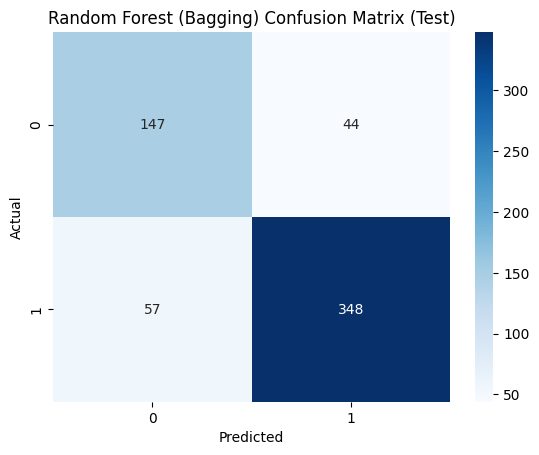

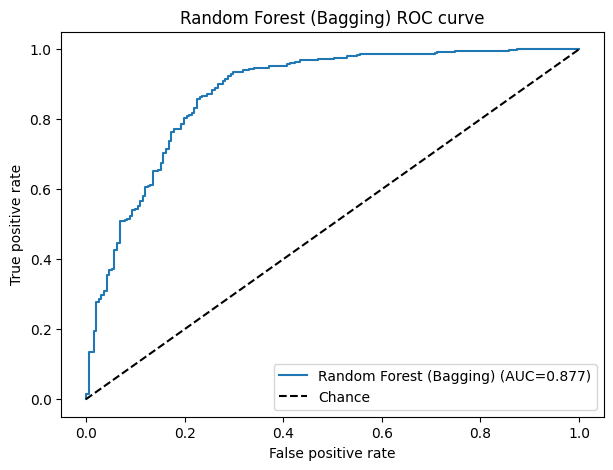

=== Boosting | Train ===
              precision    recall  f1-score   support

           0      0.778     0.847     0.811       574
           1      0.924     0.885     0.904      1211

    accuracy                          0.873      1785
   macro avg      0.851     0.866     0.857      1785
weighted avg      0.877     0.873     0.874      1785

Train ROC AUC: 0.9416455430332291

=== Boosting | Test ===
              precision    recall  f1-score   support

           0      0.756     0.764     0.760       191
           1      0.888     0.884     0.886       405

    accuracy                          0.846       596
   macro avg      0.822     0.824     0.823       596
weighted avg      0.846     0.846     0.846       596

Test ROC AUC: 0.889380130566867


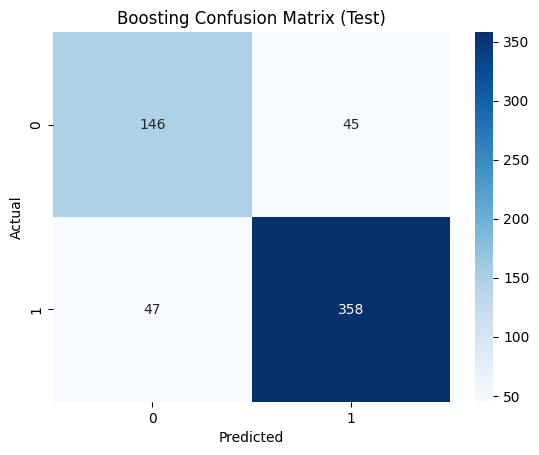

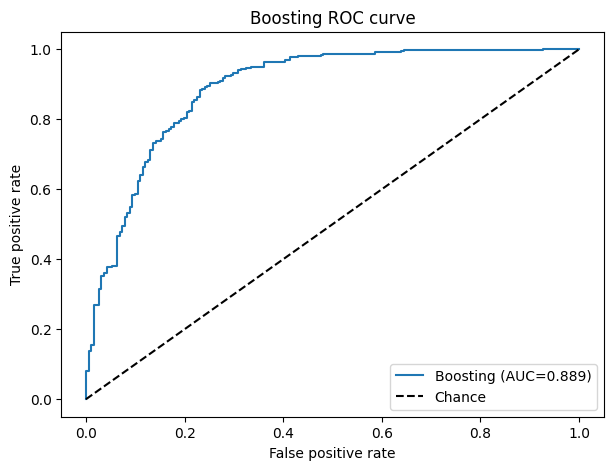

In [8]:
def evaluate(model, X_train, X_test, y_train, y_test, label="Model"):
    # Train predictions
    y_pred_train = model.predict(X_train)
    y_proba_train = model.predict_proba(X_train)[:,1] if hasattr(model, "predict_proba") else None
    y_pred_test = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    print(f"=== {label} | Train ===")
    print(classification_report(y_train, y_pred_train, digits=3))
    if y_proba_train is not None:
        print("Train ROC AUC:", roc_auc_score(y_train, y_proba_train))

    print(f"\n=== {label} | Test ===")
    print(classification_report(y_test, y_pred_test, digits=3))
    if y_proba_test is not None:
        roc = roc_auc_score(y_test, y_proba_test)
        print("Test ROC AUC:", roc)

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred_test)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"{label} Confusion Matrix (Test)")
        plt.xlabel("Predicted"); plt.ylabel("Actual")
        plt.show()

        # ROC curve
        fpr, tpr, thr = roc_curve(y_test, y_proba_test)
        plt.figure(figsize=(7,5))
        plt.plot(fpr, tpr, label=f"{label} (AUC={roc:.3f})")
        plt.plot([0,1],[0,1],'k--', label="Chance")
        plt.xlabel("False positive rate"); plt.ylabel("True positive rate")
        plt.title(f"{label} ROC curve")
        plt.legend(); plt.show()

evaluate(best_rf, X_train, X_test, y_train, y_test, label="Random Forest (Bagging)")
evaluate(best_boost, X_train, X_test, y_train, y_test, label="Boosting")


###**Interpreting features**
**Permutation importance:** Understand which inputs drive churn predictions.

**Partial dependence:** Inspect how tenure or business value affects probability.

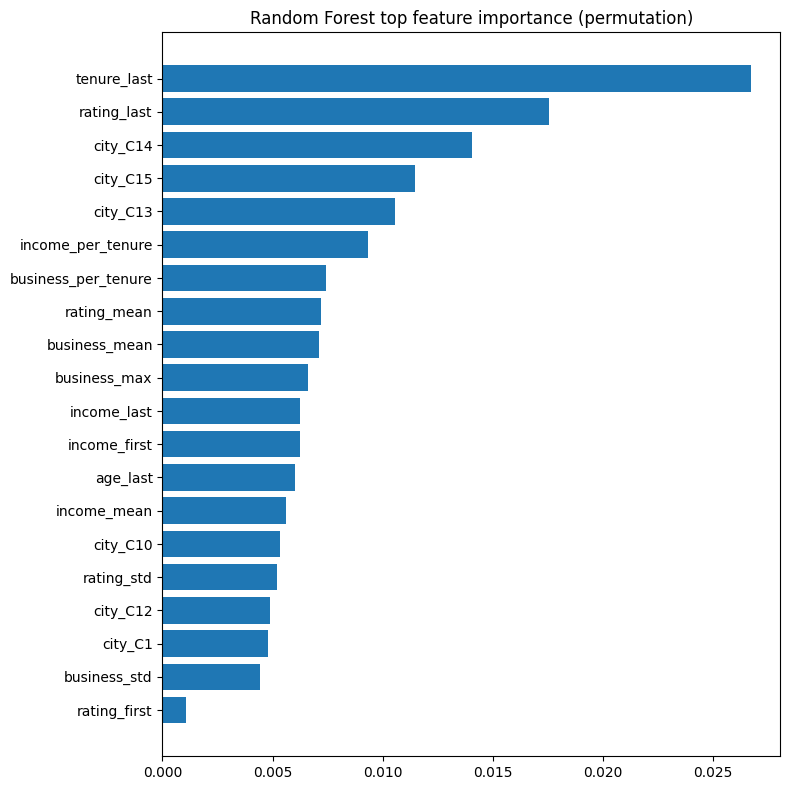

In [9]:
from sklearn.inspection import permutation_importance

def show_importance(model, X_sample, label="Model"):
    # Get feature names after preprocessing
    pre = model.named_steps['preprocess'] if 'preprocess' in model.named_steps else model['preprocess']
    # Numerical + categorical names
    num_names = numerical_features
    cat_names = pre.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(categorical_features).tolist()
    passthrough_names = binary_features
    feature_names = num_names + cat_names + passthrough_names

    # Use a subset for speed
    imp = permutation_importance(model, X_sample, y_train.sample(len(X_sample), random_state=42),
                                 n_repeats=5, random_state=42, scoring='roc_auc')
    idx = np.argsort(imp.importances_mean)[::-1][:20]
    plt.figure(figsize=(8,8))
    plt.barh(np.array(feature_names)[idx][::-1], imp.importances_mean[idx][::-1])
    plt.title(f"{label} top feature importance (permutation)")
    plt.tight_layout(); plt.show()

# Use small sample
X_small = X_train.sample(min(500, len(X_train)), random_state=42)
show_importance(best_rf, X_small, label="Random Forest")


###Mathematical note on ROC AUC
**Definition:** The ROC AUC is the probability that a randomly chosen positive instance ranks higher than a randomly chosen negative instance by the model’s score.

                AUC =∫01TPR(𝑡) 𝑑FPR(𝑡)

**Interpretation:** Values closer to 1 indicate strong separation;
0.5
 means no better than random.

###Actionable insights and recommendations

**Retention focus on early tenure:** If tenure_months is a top driver of churn, invest in onboarding, mentorship, and guaranteed-earnings floors for the first 3–6 months. Why: Newer drivers often leave before stabilizing earnings.

**Income stability beats spikes:** If income_std or business_std correlates with churn, reduce volatility with minimum fare guarantees during off-peak periods and more predictable incentive structures. Why: Income uncertainty drives exit.

**Transparent, fair incentives:** If rating_increase aligns with lower churn, tie bonuses to clear performance milestones, provide feedback loops, and coach low-rated drivers proactively. Why: Pathways to improvement keep people engaged.

**City-specific policies:** If one-hot City features rank high, deploy localized retention strategies—adjust incentives to demand cycles, address city-specific pain points (traffic, compliance). Why: Attrition drivers are regional.

**Proactive outreach:** Predict high-risk drivers weekly and trigger human touch: calls, tailored incentives, and support. Why: Intervention before disengagement is cheaper than reacquisition.

**Program A/B tests:** Pilot changes with control groups (e.g., guaranteed minimums, fuel rebates). Measure impact on weekly active days, earnings variance, and attrition. Why: Prove ROI before scaling.